# One dim bandwidth sweep

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD
from utils import dict_concatenate, dict_mean

In [2]:
n=100
d=1
stepsize = 0.01
L = 300 # 100 slightly to little, this should be all right
grid_length = 25

In [3]:
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
from utils import log_gaussian_mixture
logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWar

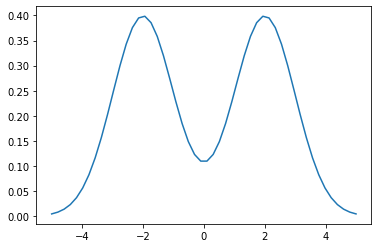

In [4]:
grid = np.linspace(-5, 5, 50)
vlogp = vmap(logp)
pdf = np.exp(vlogp(grid))
plt.plot(grid, pdf)

In [5]:
svgd_fix = SVGD(logp=logp, n_iter_max=L, adaptive_kernel=False, get_bandwidth=None)

In [6]:
def get_metrics(xout):
    """
    Compute metrics. One-dim case. Target p is gaussian mixture.
    """
    assert xout.ndim == 2
    assert xout.shape[1] == 1
    assert not np.any(np.isnan(xout))
    
    mse1 = (np.mean(xout) - 2/3)**2
    mse2 = (np.mean(xout**2) - 5)**2
    w = random.normal(rkey, (1,))
    mse3 = np.squeeze(np.mean(np.cos(w * xout)) - np.exp(-w**2 / 2))**2
    
    return [mse1, mse2, mse3]

In [7]:
def get_metrics_dict(x0):
    """
    Compute metrics in the dictionary. compare across bandwidth values in bandwidth_grid.
    
    Meant for case where x is one dimensional
    """
    assert x0.shape[1] == 1
    
    metrics_dict = {
        "E[x]": [],
        "E[x^2]": [],
        "E[cos(wx)]": []
        }

    for h in bandwidth_grid:
        xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=h, n_iter=L)
        mses = get_metrics(xout)

        for i, k in enumerate(metrics_dict.keys()):
            metrics_dict[k].append(mses[i])
    
    for k, v in metrics_dict.items():
        metrics_dict[k] = np.array(v)
            
    return metrics_dict

In [8]:
m = 1
metrics_dicts = []
for seed in range(m):
#     print(seed)
    rkey = random.PRNGKey(seed)
    x0 = random.normal(rkey, shape=(n, d)) - 10
    metrics_dict = get_metrics_dict(x0)
    metrics_dicts.append(metrics_dict)

In [9]:
mse_dict = dict_mean(metrics_dicts)

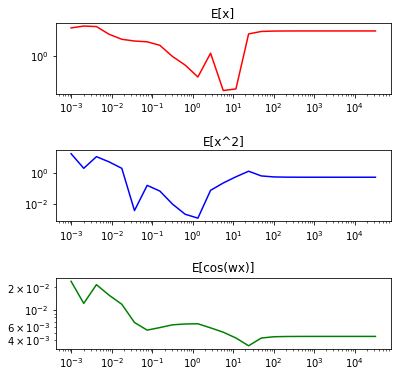

In [10]:
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
plt.subplots_adjust(hspace=0.8)
col = ["r", "b", "g"]
for i, key in enumerate(mse_dict.keys()):
    plt.subplot(f"31{i+1}")
    plt.title(key)
    plt.plot(bandwidth_grid, mse_dict[key], col[i])
    plt.xscale('log')
    plt.yscale('log')

In [20]:
x0 = random.normal(rkey, shape=(n, d)) - 10

In [21]:
xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=1, n_iter=L)

In [22]:
mses = get_metrics(xout)

In [23]:
print(mses)

[DeviceArray(0.5504136, dtype=float32), DeviceArray(0.00136436, dtype=float32), DeviceArray(0.00658151, dtype=float32)]


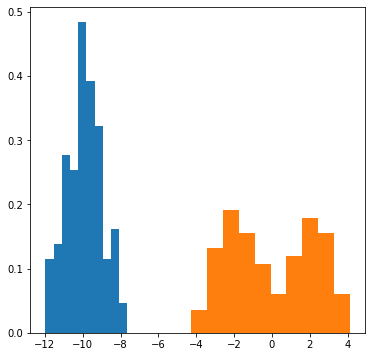

In [24]:
plt.figure(1)
_ = plt.hist(x0[:, 0], density=True)
_ = plt.hist(xout[:, 0], density=True)

In [ ]:
# mpl.rcParams['figure.figsize'] = [6.0, 6.0]
# plt.subplots_adjust(hspace=0.8)
# col = ["r", "b", "g"]
# for i, metric in enumerate(mses):
#     plt.subplot(f"31{i+1}")
#     plt.title(metric)
#     plt.plot(bandwidth_grid, metric, col[i])
#     plt.xscale('log')
#     plt.yscale('log')

# same thing, but in two dims

In [9]:
n=100
d=2
stepsize = 0.01
L = 100
grid_length = 25

In [10]:
bandwidth_grid = np.logspace(-10, 15, num=grid_length, base=2)
bandwidth_grid = bandwidth_grid[:, np.newaxis]
for _ in range(d-1):
    bandwidth_grid = np.concatenate([bandwidth_grid, np.ones((grid_length, 1))], axis=1)
bandwidth_grid.shape

from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [13]:
def get_mse_dict2(x0):
    mse_dict = {
        "E[x]": [],
        "E[x^2]": []
#         "E[cos(wx)]": []
        }
    for h in bandwidth_grid:
        xout, log = svgd_fix.svgd(x=x0, stepsize=stepsize, bandwidth=h)
        assert not np.any(np.isnan(xout))

        mse1 = (np.mean(xout, axis=0) - 0)**2
        mse2 = (np.mean(xout**2, axis=0) - 1)**2
#         w = random.normal(rkey, (1,))
#         mse3 = (np.mean(np.cos(w * xout), axis=0) - np.exp(-w**2 / 2))**2
#         mses = [mse1, mse2, mse3]
        mses = [mse1, mse2]

        for i, k in enumerate(mse_dict.keys()):
            mse_dict[k].append(mses[i])
    
    for k, v in mse_dict.items():
        mse_dict[k] = np.array(v)
            
    return mse_dict

In [14]:
m = 50
mse_dicts2 = []
for seed in range(m):
    rkey = random.PRNGKey(seed)
    x0 = random.normal(rkey, shape=(n, d)) - 10
    mse_dict = get_mse_dict2(x0)
    mse_dicts2.append(mse_dict)

In [15]:
mse_dict2 = dict_mean(mse_dicts2)

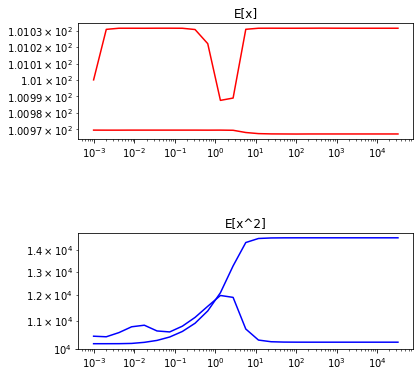

In [16]:
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
plt.subplots_adjust(hspace=0.8)
col = ["r", "b", "g"]
l = len(mse_dict2)
for i, key in enumerate(mse_dict.keys()):
    plt.subplot(f"{l}1{i+1}")
    plt.title(key)
    plt.plot(bandwidth_grid[:, 0], mse_dict[key], col[i])
    plt.xscale('log')
    plt.yscale('log')

# multidim random grid search

In [17]:
stepsize = 0.01
L = 1000
key = random.PRNGKey(0)
kernel_param_grid_old = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful

kernel_param_grid = random.uniform(key, shape=(25, d)) * 25 - 10
kernel_param_grid = 2**kernel_param_grid
kernel_param_grid = kernel_param_grid[kernel_param_grid[:, 0].argsort()]

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [ ]:
grid = np.